# Model evaluation

We evaluate our trained neural networks by:
* Plotting the learning curves (loss history) on training & validation set
* Plotting NN predictions for few selected trajectories
* Computing train/valid loss for each output variable separately

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')

In [2]:
# Load exported models' metric data (train/valid loss over epochs)
# into two dictionaries 'train_err', 'valid_err'
# indexed by model name
def get_metrics_data(mdl_names):
    train_err = dict()
    valid_err = dict()
    
    for mdl_name in mdl_names:
        path_to_file = 'models/' + mdl_name + '/metrics.npz'
        loaded_arrs = np.load(path_to_file)
        
        train_err[mdl_name] = loaded_arrs['train_loss']
        valid_err[mdl_name] = loaded_arrs['val_loss']

    return train_err, valid_err

We have trained networks on two different datasets:
* Quadratic optimal control (QOC)
* Mass optimal control (MOC)

Details on dataset generation can be found [here](https://arxiv.org/abs/1802.00180) and [code](https://github.com/cisprague/act-ai) (C. Sprague).

For both cases, our networks represent a mapping from state $\mathbf{s}$ to control $\mathbf{u}$.

We have:<br>
$\mathbf{s} \in \mathbb{R}^7$<br>
$\mathbf{u} = [u, \phi, \Theta]^T$

i.e. this corresponds to a network with input dimensionality 7 and output dimensionality 3.

We also experiment by predicting fewer than the 3 output variables in a single network: $\mathbf{s} \rightarrow \mathbf{u}'$ where:
* *all* : $\mathbf{u}' = \mathbf{u}$<br>
* *u* : $\mathbf{u}' = \{u\}$<br>
* *vector* : $\mathbf{u}' = \{\phi, \Theta\}$<br>
* *vector_phi* : $\mathbf{u}' = \{\phi\}$<br>
* *vector_theta* : $\mathbf{u}' = \{\Theta\}$<br>

The best network architecture and other hyperparameters is still under investigation.<br>

The network configuration investigated below:<br>
* \# hidden layers = 4
* \# units/layer = 200
* activation func (hidden) = relu
* activation func (output) = tanh

This is the result of a prior investigation into best architecture for the *u*-network.

Along with optimiser: *(see train_network.py for further details)*
* Adam with initial learning rate $10^{-3}$
* Learning rate multiplied by $10^{-1}$ on training loss plateau
* MSE loss function

In [3]:
mdl_names = ['moc_l4_n200_all',
             'moc_l4_n200_u',
             'moc_l4_n200_vector',
             'moc_l4_n200_vector_phi',
             'moc_l4_n200_vector_theta',
             'qoc_l4_n200_all',
             'qoc_l4_n200_u',
             'qoc_l4_n200_vector',
             'qoc_l4_n200_vector_phi',
             'qoc_l4_n200_vector_theta']

train_err, valid_err = get_metrics_data(mdl_names)

### Learning curves

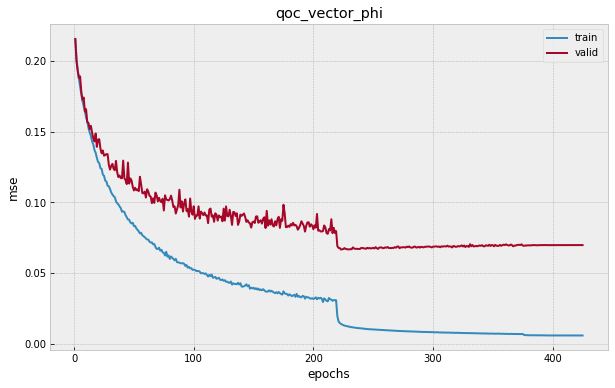

Final training error: 0.0058
Final validation error: 0.0698
Number of epochs: 425


In [5]:
plt.figure(figsize=(10,6))

type_data = 'qoc' # qoc, moc
type_out = 'vector_phi' # all, u, vector, vector_phi, vector_theta

train_data = train_err[type_data + '_l4_n200_' + type_out]
plt.plot(np.arange(np.size(train_data))+1, train_data, label='train')

valid_data = valid_err[type_data + '_l4_n200_' + type_out]
plt.plot(np.arange(np.size(valid_data))+1, valid_data, label='valid')

plt.title(type_data + '_' + type_out)
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

plt.show()

print('Final training error: {0:.4f}'.format(train_data[-1]))
print('Final validation error: {0:.4f}'.format(valid_data[-1]))
print('Number of epochs: {0}'.format(train_data.size))

In [7]:
from keras.models import load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### NN Predictions (MOC)

In [10]:
network_output = 'all' # all, u, vector, vector_phi, vector_theta
model_type = 'best_model_train' # best_model_train, best_model_val

mdl_name =  'moc_l4_n200_' + network_output
path_to_model = 'models/' + mdl_name + '/' + model_type + '.h5'
model = load_model(path_to_model) # trained keras model loaded to make predictions

data = np.load('datasets/moc_data_sph.npy')
inputs = data[:, [0,1,2,3,4,5,6]]
input_scaler = StandardScaler().fit(inputs) # need same input scaler as used in training

# output variables to display based on network choice
if network_output == 'all':
    target_indices = [7,8,9]
    plot_lbls = ['$u$', '$u_\phi$', '$u_\Theta$']
elif network_output == 'u':
    target_indices = [7]
    plot_lbls = ['$u$']
elif network_output == 'vector':
    target_indices = [8,9]
    plot_lbls = ['$u_\phi$', '$u_\Theta$']
elif network_output == 'vector_phi':
    target_indices = [8]
    plot_lbls = ['$u_\phi$']
elif network_output == 'vector_theta':
    target_indices = [9]
    plot_lbls = ['$u_\Theta$']
    
# need same target scaler as used in training
targets = data[:, target_indices]
target_scaler = MinMaxScaler(feature_range=(-1, 1),).fit(targets)

# load data file that contains trajectory times
data_with_times = np.load('datasets/moc_data.npy')
# split data into separate trajectories
traj_split_indices = np.where(data_with_times[:, 0] == 0.)[0][1:] # time=0 indicates start of new trajectory
data_trajs_times = np.split(data_with_times, traj_split_indices)
data_trajs = np.split(data, traj_split_indices)

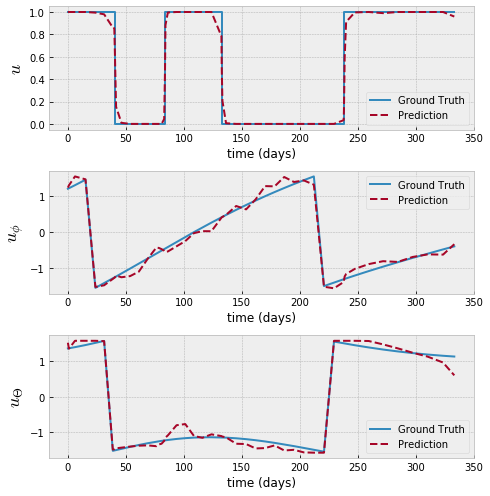

Display trajectory 4/3085


In [14]:
traj_idx = 3 # trajectory to plot

plt.figure(figsize=(7, 7))

# for x-axis
times = data_trajs_times[traj_idx][:, 0]

# compute network predictions
inputs = data_trajs[traj_idx][:, [0,1,2,3,4,5,6]]
inputs_norm = input_scaler.transform(inputs)
preds = target_scaler.inverse_transform(model.predict(inputs_norm))

# num plots displayed corresponds to network outputs
i = 0
for target_idx in target_indices:
    plt.subplot(3,1,i+1)
    y_true = data_trajs[traj_idx][:, target_idx]
    plt.plot(times, y_true, label='Ground Truth')
    plt.plot(times, preds[:,[i]] , '--', label='Prediction')
    plt.xlabel('time (days)')
    plt.ylabel(plot_lbls[i], fontsize=18)
    plt.legend()
    i += 1
    
plt.tight_layout()
plt.show()

print('Display trajectory {0}/{1}'.format(traj_idx+1, len(data_trajs)))

### NN Predictions (QOC)

In [16]:
network_output = 'all' # all, u, vector, vector_phi, vector_theta
model_type = 'best_model_train' # best_model_val

mdl_name = 'qoc_l4_n200_' + network_output
path_to_model = 'models/' + mdl_name + '/' + model_type + '.h5'
model = load_model(path_to_model) # trained keras model loaded to make predictions

data = np.load('datasets/qoc_data_sph.npy')
inputs = data[:, [0,1,2,3,4,5,6]]
input_scaler = StandardScaler().fit(inputs)
inputs_norm = input_scaler.transform(inputs)

# output variables to display based on network choice
if network_output == 'all':
    target_indices = [7,8,9]
    plot_lbls = ['$u$', '$u_\phi$', '$u_\Theta$']
elif network_output == 'u':
    target_indices = [7]
    plot_lbls = ['$u$']
elif network_output == 'vector':
    target_indices = [8,9]
    plot_lbls = ['$u_\phi$', '$u_\Theta$']
elif network_output == 'vector_phi':
    target_indices = [8]
    plot_lbls = ['$u_\phi$']
elif network_output == 'vector_theta':
    target_indices = [9]
    plot_lbls = ['$u_\Theta$']

targets = data[:, target_indices]
target_scaler = MinMaxScaler(feature_range=(-1, 1),).fit(targets)

# split data into separate trajectories
# we do not have time variable for qoc data so we split on large jump in throttle value
traj_split_indices = np.where(np.absolute(np.diff(data[:,7], axis=0)) > 0.1)[0]+1
inputs_trajs = np.split(inputs_norm, traj_split_indices)
targets_trajs = np.split(targets, traj_split_indices)

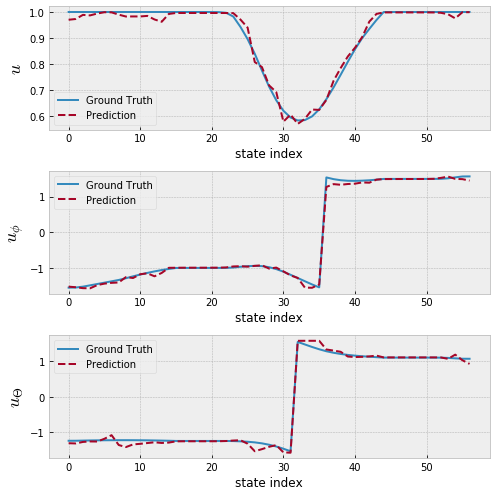

Display trajectory 2/3494


In [18]:
traj_idx = 1 # trajectory to plot

plt.figure(figsize=(7, 7))

truth = targets_trajs[traj_idx]
# network predictions
preds = target_scaler.inverse_transform(model.predict(inputs_trajs[traj_idx]))

times = np.arange(preds.shape[0]) # not really 'time'

i = 0
for target_idx in target_indices:
    plt.subplot(3,1,i+1)
    plt.plot(times, truth[:,i], label='Ground Truth')
    plt.plot(times, preds[:,i] , '--', label='Prediction')
    plt.xlabel('state index')
    plt.ylabel(plot_lbls[i], fontsize=18)
    plt.legend()
    i += 1
    
plt.tight_layout()
plt.show()

print('Display trajectory {0}/{1}'.format(traj_idx+1, len(inputs_trajs)))

### MSE for output variable separately

In [19]:
from sklearn.model_selection import train_test_split
rnd_seed = 170118

In [21]:
type_data = 'qoc' # qoc, moc
network_out = 'all' # all, u, vector, vector_phi, vector_theta
model_type = 'best_model_train' # best_model_val

mdl_name = type_data + '_l4_n200_' + network_out
path_to_model = 'models/' + mdl_name + '/' + model_type + '.h5'
model = load_model(path_to_model)

data = np.load('datasets/' + type_data + '_data_sph.npy')
inputs = data[:, [0,1,2,3,4,5,6]]
input_scaler = StandardScaler().fit(inputs)
inputs_norm = input_scaler.transform(inputs)

if network_output == 'all':
    target_indices = [7,8,9]
    var_lbls = ['u', 'phi', 'theta']
elif network_output == 'u':
    target_indices = [7]
    var_lbls = ['u']
elif network_output == 'vector':
    target_indices = [8,9]
    var_lbls = ['phi', 'theta']
elif network_output == 'vector_phi':
    target_indices = [8]
    var_lbls = ['phi']
elif network_output == 'vector_theta':
    target_indices = [9]
    var_lbls = ['theta']

targets = data[:, target_indices]
target_scaler = MinMaxScaler(feature_range=(-1, 1),).fit(targets)
targets_norm = target_scaler.transform(targets)

X_train, X_test, y_train, y_test = train_test_split(inputs_norm, targets_norm, test_size=0.1, random_state=rnd_seed)

preds_train = model.predict(X_train)
preds_valid = model.predict(X_test)
for i, (target_idx, var_lbl) in enumerate(zip(target_indices, var_lbls)):
    y_pred = preds_train[:,i]
    y_true = y_train[:,i].flatten()
    train_err = np.mean(np.square(y_pred - y_true), axis=-1)
    
    y_pred = preds_valid[:,i]
    y_true = y_test[:,i].flatten()
    valid_err = np.mean(np.square(y_pred - y_true), axis=-1)    
    
    print('{0} - Train err: {1:.6f}'.format(var_lbl, train_err))
    print('{0} - Valid err: {1:.6f}'.format(var_lbl, valid_err))
    print()

u - Train err: 0.009995
u - Valid err: 0.017762

phi - Train err: 0.008398
phi - Valid err: 0.069020

theta - Train err: 0.017774
theta - Valid err: 0.087009

